RAIN - Real & Artificial Intelligence for Neuroscience

## Create models
- This notebook will create and train Artificial Neural Networks to identify exploration using rodent and target position along with manually labeled data.

#### Requirements:

- A set of position files
- Labeled data for those position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - Manual labels from 5 viewers (so far)

---
#### Load the necessary modules

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime # Often useful for timestamps

# Import all necessary functions from the refactored modules
from rainstorm.modeling.data_preparation import prepare_data, focus
from rainstorm.modeling.model_management import create_modeling, load_modeling_config, save_split, save_model, build_and_run_models
from rainstorm.modeling.model_building import build_RNN
from rainstorm.modeling.model_training import split_tr_ts_val, train_RNN
from rainstorm.modeling.model_evaluating import build_evaluation_dict, create_chimera_and_loo_mean, calculate_cosine_sim, plot_PCA, plot_history, plot_performance_on_video
from rainstorm.modeling.utils import recenter # If you use recenter

---
#### 1. State your models project path
`base` : The path to the downloaded repository.

`models_folder` : The path to the folder containing the files you'll use to create the models.

In [2]:
# Define your base path (e.g., to the Rainstorm repository)
base = Path(r'C:\Users\dhers\Desktop\Rainstorm')
models_folder = base / r'examples\models'

---
#### 2.  Create the modeling.yaml file

The modeling.yaml file is a configuration file that contains all the parameters needed to create and train the models. It will be located in the models folder.

In [3]:
modeling_yaml_path = create_modeling(models_folder)

# Load the configuration
modeling_config = load_modeling_config(modeling_yaml_path)

# Access paths from the config
colabels_path = Path(modeling_config["colabels"]["colabels_path"])
# If you need to override labelers from the default config:
labelers_from_config = modeling_config["colabels"]["labelers"]
target_from_config = modeling_config["colabels"]["target"]
bodyparts_from_config = modeling_config["bodyparts"]

INFO:rainstorm.modeling.model_management:✅ modeling.yaml already exists: C:\Users\dhers\Desktop\Rainstorm\examples\models\modeling.yaml
Skipping creation.



It contains the following parameters:

`path` : Path to the models folder

`colabels` : The colabels file is used to store and organize positions and labels for model training
- colabels_path: Path to the colabels folder
- labelers: List of labelers on the colabels file (as found in the columns)
- target: Name of the target on the colabels file

`focus_distance`: Window of frames to consider around an exploration event

`bodyparts`: List of bodyparts used to train the model

`split`: Parameters for splitting the data into training, validation, and testing sets
- validation: Percentage of the data to use for validation
- test: Percentage of the data to use for testing

`RNN`: Set up the Recurrent Neural Network
- width: Defines the shape of the wide model
  - past : Number of past frames to include
  - future : Number of future frames to include
  - broad : Broaden the window by skipping some frames as we stray further from the present
- units: Number of neurons on each layer
- batch_size: Number of training samples the model processes before updating its weights
- epochs: Each epoch is a complete pass through the entire training dataset
- lr: Learning rate


---
#### 3. Before training a model, we need to prepare our training data
- First, we load the dataset from the colabels file and create one 'labels' column out of all the labelers.
- Next (optional, but recommended) we can erase the rows of the dataset that are too far away from exploration events.
- Finally, we split the dataset into training, testing and validation subsets.

In [4]:
# Prepare the data
# This function handles loading colabels, smoothing, and sigmoid transformation internally.
df_processed = prepare_data(modeling_yaml_path)

# Filter data to focus on relevant periods
df_focused = focus(modeling_yaml_path, df_processed, filter_by='labels')

# If you still need to recenter (e.g., if you only recenter *after* focusing):
# df_final = recenter(df_focused.drop(columns=['labels']), bodyparts=bodyparts_from_config) # Drop labels before recentering if it's not a position
# df_final['labels'] = df_focused['labels'] # Add labels back

INFO:rainstorm.modeling.data_preparation:🧹 Smoothing column: labels
INFO:rainstorm.modeling.data_preparation:🔍 Focusing based on 'labels', with distance ±30 frames
INFO:rainstorm.modeling.data_preparation: ▶ Original rows: 167012
INFO:rainstorm.modeling.data_preparation: ▶ Found 10231 event rows
INFO:rainstorm.modeling.data_preparation: ✅ Filtered rows: 38161


In [5]:
# Split the data into training, validation, and test sets
model_data_splits = split_tr_ts_val(modeling_yaml_path, df_focused, bodyparts=bodyparts_from_config)

# You can access splits like:
X_tr_wide = model_data_splits['X_tr_wide']
y_tr = model_data_splits['y_tr']
X_val_wide = model_data_splits['X_val_wide']
y_val = model_data_splits['y_val']
X_ts_wide = model_data_splits['X_ts_wide']
y_ts = model_data_splits['y_ts']

# Save the split data (optional, but good practice)
save_split(modeling_yaml_path, model_data_splits)

INFO:rainstorm.modeling.model_training:📊 Splitting data into training, validation, and test sets...
INFO:rainstorm.modeling.model_training:  Training samples: 26713
INFO:rainstorm.modeling.model_training:  Validation samples: 5724
INFO:rainstorm.modeling.model_training:  Test samples: 5724
INFO:rainstorm.modeling.model_training:  Reshaped X_tr_wide shape: (26713, 7, 12)
INFO:rainstorm.modeling.model_training:  Reshaped X_val_wide shape: (5724, 7, 12)
INFO:rainstorm.modeling.model_training:  Reshaped X_ts_wide shape: (5724, 7, 12)
INFO:rainstorm.modeling.model_management:💾 Saved split data to: C:\Users\dhers\Desktop\Rainstorm\examples\models\splits\split_2025-06-07.h5


---
#### 5. Now that we have a simple model trained, we can start building more complex models

To make our artificial networks as real as possible, we can let them see a sequence of frames to decide if the mouse is exploring
- Our build_RNN function will use Bidirectional LSTM layers that allow the model to take into account the temporal sequence of frames
- It also implements early stopping and learning rate scheduler mechanisms that will prevent the model from overfitting

We can control the RNN model by changing the following parameters on the modeling.yaml file:

`units` : The number of neurons on each layer of the LSTM model

`batch_size` : The number of training samples the model processes before updating its weights

`lr` : The learning rate of the model

`epochs` : The number of times the model will be trained on the entire training dataset

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as it strays further from the present.

In [6]:
# Build the RNN model
model_name = "my_first_rnn_model" # Give your model a meaningful name
model = build_RNN(modeling_config, model_data_splits)

[7, 12]
Model: "ModularBidirectionalRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence (InputLayer)    [(None, 7, 12)]      0           []                               
                                                                                                  
 bilstm_0 (Bidirectional)       (None, 7, 32)        3712        ['input_sequence[0][0]']         
                                                                                                  
 bn_0 (BatchNormalization)      (None, 7, 32)        128         ['bilstm_0[0][0]']               
                                                                                                  
 dropout_0 (Dropout)            (None, 7, 32)        0           ['bn_0[0][0]']                   
                                                                    

#### Train the model

In [7]:
# Train the model
history = train_RNN(modeling_yaml_path, model, model_data_splits, model_name=model_name)

# Save the trained model
save_model(modeling_yaml_path, model, model_name=model_name)

INFO:rainstorm.modeling.model_training:🚀 Starting training for model: my_first_rnn_model


Epoch 1/100
418/418 [==============================] - 25s 32ms/step - loss: 1.2141 - accuracy: 0.4192 - val_loss: 0.8889 - val_accuracy: 0.4268 - lr: 1.0000e-05
Epoch 2/100
418/418 [==============================] - 11s 25ms/step - loss: 1.0246 - accuracy: 0.4308 - val_loss: 0.8279 - val_accuracy: 0.4324 - lr: 1.9000e-05
Epoch 3/100
418/418 [==============================] - 11s 26ms/step - loss: 0.8857 - accuracy: 0.4561 - val_loss: 0.7225 - val_accuracy: 0.4874 - lr: 2.8000e-05
Epoch 4/100
418/418 [==============================] - 12s 28ms/step - loss: 0.7673 - accuracy: 0.5059 - val_loss: 0.6337 - val_accuracy: 0.5734 - lr: 3.7000e-05
Epoch 5/100
418/418 [==============================] - 13s 31ms/step - loss: 0.6755 - accuracy: 0.5665 - val_loss: 0.5899 - val_accuracy: 0.6427 - lr: 4.6000e-05
Epoch 6/100
418/418 [==============================] - 13s 32ms/step - loss: 0.6267 - accuracy: 0.6138 - val_loss: 0.5700 - val_accuracy: 0.6707 - lr: 5.5000e-05
Epoch 7/100
418/418 [=======

INFO:rainstorm.modeling.model_training:✅ Training for model 'my_first_rnn_model' completed.
INFO:rainstorm.modeling.model_management:✅ Model 'my_first_rnn_model' saved to: C:\Users\dhers\Desktop\Rainstorm\examples\models\trained_models\my_first_rnn_model.keras


179/179 [==============================] - 1s 7ms/step
Test Set Metrics: {'MSE': 0.15658383362732506, 'MAE': 0.3379414437908151, 'R2': 0.004192088209403089, 'Accuracy': 0.7681691125087351, 'Precision': 0.0, 'Recall': 0.0, 'F1_Score': 0.0}


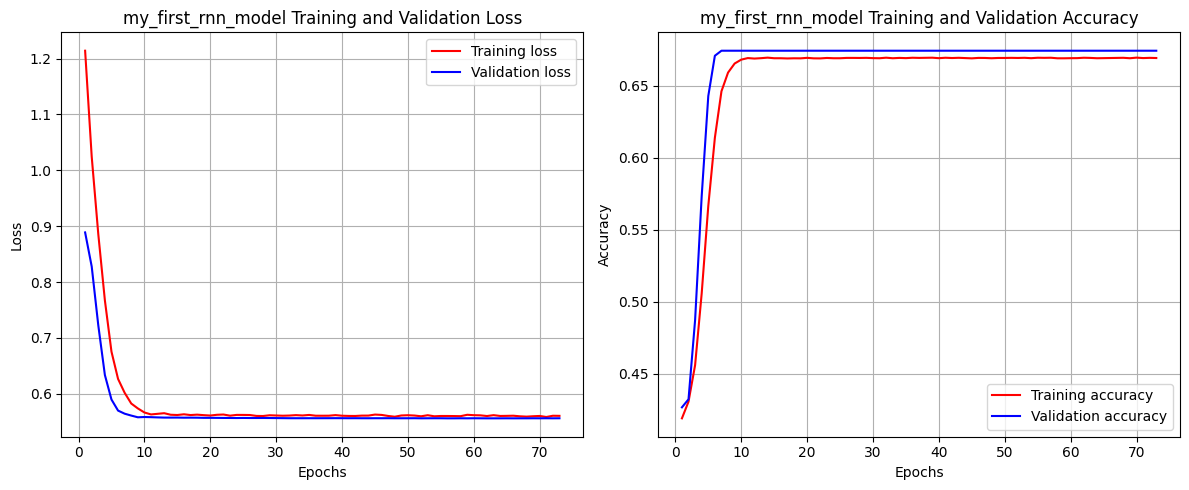

In [9]:
# Evaluate the model on the test set
test_metrics = build_evaluation_dict(y_true=model_data_splits['y_ts'], y_pred=model.predict(model_data_splits['X_ts_wide']))
print("Test Set Metrics:", test_metrics)

# Plot training history
plot_history(history, model_name)

In [11]:
# Example for plot_performance_on_video:
# You'll need to define the exact path to your example video folder
# and the paths to the labeler files for that specific video.
example_video_folder = base / "examples" / "colabeled_video" # Adjust this path

# Define the model paths (pointing to the .keras file you just saved)
model_paths = {
    model_name: (models_folder / "trained_models" / f"{model_name}.keras")
}

# Example labeler files for a specific video (replace with your actual paths relative to example_video_folder)
labelers_example = {
    "labeler_A": "Example_labeler_A.csv", # Assuming these are in example_video_folder/labeler_A/
    "labeler_B": "Example_labeler_B.csv",
    "labeler_C": "Example_labeler_C.csv",
    "labeler_D": "Example_labeler_D.csv",
    "labeler_E": "Example_labeler_E.csv",
}

plot_performance_on_video(
    folder_path=example_video_folder, # This path should contain the 'positions' folder and labeler subfolders
    model_paths=model_paths,
    labelers=labelers_example,
    fps=25, # Your video's FPS
    bodyparts=bodyparts_from_config,
    targets=["obj_1", "obj_2"], # Your target objects
    plot_tgt="obj_2" # The specific target you want to plot
)

FileNotFoundError: Corresponding position file not found for plotting: C:\Users\dhers\Desktop\Rainstorm\examples\colabeled_video\positions\Example_labeler_A.csv. Ensure the position file naming convention matches labeler files or specify it directly.